In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  1377k      0  0:09:44  0:09:44 --:--:-- 1430k     0  1760k      0  0:07:37  0:00:39  0:06:58 1773k  0:07:45  0:02:43  0:05:02 1001k  0:07:55  0:02:58  0:04:57 1412k     0  1578k      0  0:08:30  0:04:25  0:04:05 1613k  0:08:30  0:04:38  0:03:52 1783k0  0:09:04  0:06:01  0:03:03  873k 0     0  1463k      0  0:09:10  0:06:08  0:03:02  745k39k      0  0:09:19  0:06:25  0:02:54 1081k16k      0  0:09:28  0:07:28  0:02:00 1183k 0     0  1408k      0  0:09:32  0:08:10  0:01:22 1271k:09:33  0:08:13  0:01:20  859k0:09:34  0:08:23  0:01:11 1424k     0  1390k      0  0:09:39  0:09:03  0:00:36 1071k


In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

API_finished_project.ipynb
Amazon Bestsellers .ipynb
Applications
Bayesian_optimization_case_study.ipynb
Capstone 2 Data Wrangling.ipynb
Capstone 2 EDA.ipynb
Capstone 2 Heart Failure Modeling .ipynb
Capstone 3 .ipynb
Clustering Case Study - Customer Segmentation with K-Means - Tier 1.ipynb
Clustering Case Study - Customer Segmentation with K-Means - Tier 3.ipynb
Cosine_Similarity_Case_Study.ipynb
Cowboy Cigarettes Case Study - Tier 1.ipynb
Cowboy Cigarettes Case Study - Tier 3.ipynb
Data Storytelling.ipynb
Desktop
Documents
Downloads
Euclidean_and_Manhattan_Distances_Case_Study (1).ipynb
Feature Engineering.ipynb
Frequentist Inference Case Study - Part A (3).ipynb
Frequentist Inference Case Study - Part B (2).ipynb
Gradient Boosting Case Study.ipynb
GridSearchKNN_Case_Study.ipynb
Heart Failure Capstone Notebook.ipynb
Image Classification.ipynb
Interview Practice .ipynb
Library
Logistic Regression Advanced Case Study.ipynb
MSR-LA - 3467.docx
Melanoma Tumor Classification.ipynb
Movies
Mu

In [4]:
!ls PetImages

Cat Dog


In [5]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [6]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


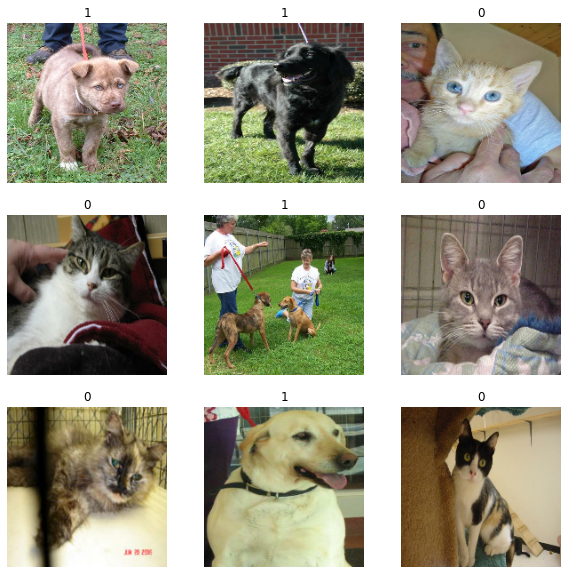

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

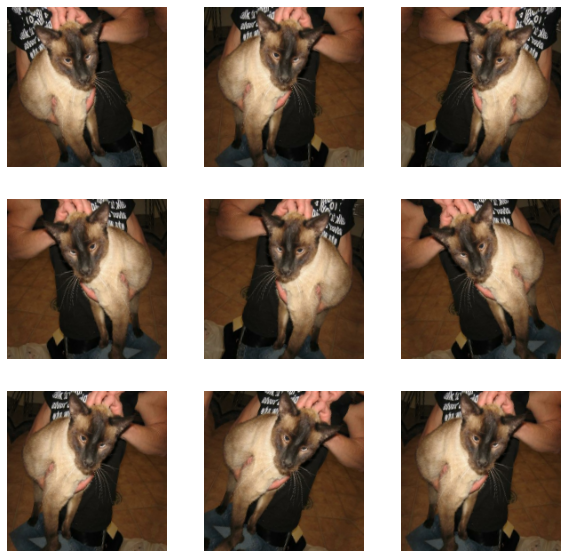

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [13]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [14]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32) 

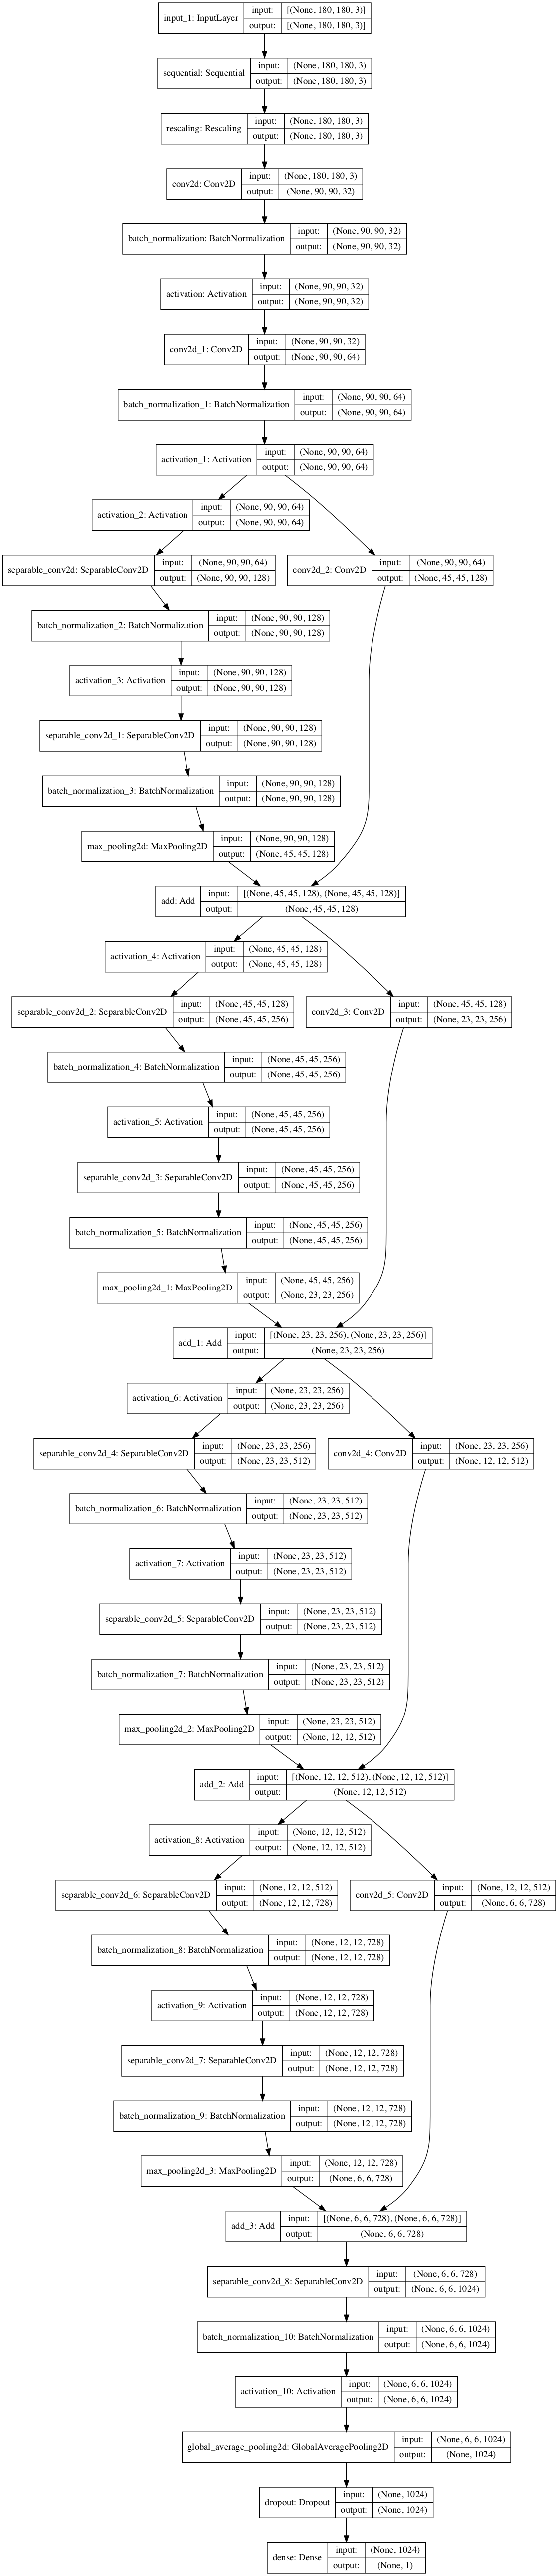

In [15]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [16]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
265/586 [============>.................] - ETA: 1:05:29 - loss: 0.7205 - accuracy: 0.5805

KeyboardInterrupt: 

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)